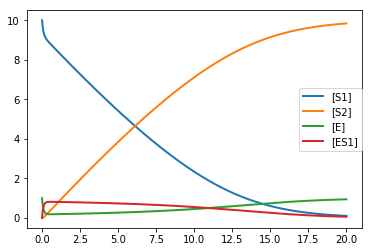

In [144]:
# example-2a: enzyme
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt

te.setDefaultPlottingEngine('matplotlib')

model = """
model test
    compartment C1;
    C1 = 1.0;
    species S1, S2, E, ES1;

    S1 = 10.0;
    S2 = 0.0;
    E = 1.0;
    ES1 = 0.0;
    S1 in C1; S2 in C1; E in C1; ES1 in C1;
    J1: S1 + E -> ES1; S1*E*kf;  #fwd
    J2: ES1 -> S1 + E; ES1*kr;  #rwd
    J3: ES1 -> S2 + E; ES1*kc;   #catalytic

    kf = 1.0; kr = 1.0; kc = 1.0;
end
"""
# load models
r = te.loada(model)


## set additional parameters
S1range = [0.5,1, 2, 4, 8, 16, 32, 64, 128, 256, 512] # range of substrate concentration



# simulate from 0 to 50 with 100 steps
r.simulate(0, 20, 500)
# plot the simulation
r.plot()

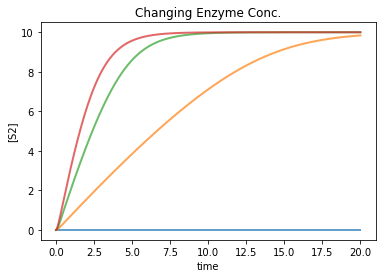

(500, 5)


array([1.56312625, 2.40480962, 6.49298597])

In [145]:
# varying E initial
r['[E]'] = 0
Erange = [0, 1, 3, 5] # range of enzyme concentration to try
r.reset() # re-seting simulation result
m = r.simulate (0, 20, 500, selections=["time"]) #make time array

for i in range (0,4):
    r.reset()
    r['[E]'] = Erange[i] # set enzyme concentration level
    res = r.simulate (0, 20, 500, selections=["S2"])
    m = np.concatenate([m, res], axis=1)
    #print("pp"+ str(i))

# te.plotArray generate a plot using the first column of the array for dependent variable and other columns as independent variables

te.plotArray(m, alpha=0.7, loc=None,
             xlabel="time", ylabel="[S2]", title="Changing Enzyme Conc.");

print(str(m.shape)) # dimension of output
#print(m[:,0]) # print out time array
#print(m[:,3]) # print simulation result for parameter set Erange


# estimate reaction rate
# find time point where [S2] is half of [S2]max

finalM = m[-1,2:] # [S2] at final time point ~ [S2]max
timecourseM = m[:,2:]
#print(finalM)

diffMmid = abs(timecourseM-(finalM/2))
minInColumns = np.amin(diffMmid, axis=0)
#print(minInColumns)
ind = np.where(minInColumns == diffMmid)[0] # index of mid time
timepoint = m[:, 0]
timepoint[ind]

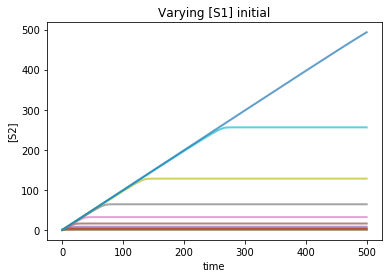

In [146]:
# varying S1 initial
r['[S1]'] = 0
r.kr = 1
r.reset() # re-seting simulation result
m = r.simulate (0, 500, 1000, selections=["time"]) #make time array

for i in range (0,len(S1range)):
    r.reset()
    r['[S1]'] = S1range[i] # set substrate concentration level
    res = r.simulate (0, 500, 1000, selections=["S2"])
    m = np.concatenate([m, res], axis=1)
    #print("pp"+ str(i))

    
    
#### plot timecourse increments of reaction product    
# te.plotArray generate a plot using the first column of the array for dependent variable and other columns as independent variables

te.plotArray(m, alpha=0.7, loc=None,
             xlabel="time", ylabel="[S2]", title="Varying [S1] initial");





                                                                                                                                                                                                                                                                                                                                                                       


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text xticklabel objects>)

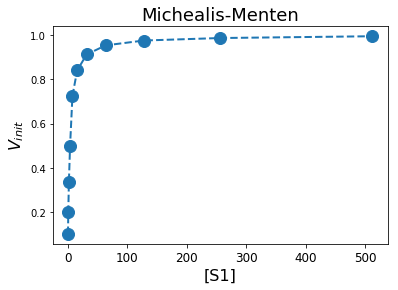

In [147]:
#### plot Michealis-Menten
# estimate reaction rate
# find time point where [S2] is half of [S2]max

initM = m[0, 1:]
finalM = m[-1,1:] # [S2] at final time point ~ [S2]max ** first column ~ time
timecourseM = m[:,1:] # timecourse [S2] for each different initial [S1]
#print(finalM)

#find the differences between 1/2 [S2]max and each [S2] value in the timecourse
#the minimal absolute difference would be where [S2] ~ 1/2 [S2]max
diffMmid = abs(timecourseM-(finalM/2)) 
# find that minimum difference values
minInColumns = np.amin(diffMmid, axis=0)
# find the index where where [S2] ~ 1/2 [S2]max
ind = np.where(minInColumns == diffMmid)[0] # index of mid time
timepoint = m[:, 0] # time point array from time course simulation 
thalf = timepoint[ind] # find out at what time point when [S2] ~ 1/2 [S2]max

# estimate initial reaction velocity
Vinit = ((finalM/2) - initM) / thalf

fig = plt.plot(S1range, Vinit, marker='o', linestyle='dashed',
              linewidth=2, markersize=12)
plt.xlabel("[S1]", fontsize=16)
plt.ylabel("$V_{init}$", fontsize=16)
plt.title("Michealis-Menten", fontsize=18)
plt.xticks(fontsize=12)

Vmax = 1.0998878626352095
Km = 4.888229598081494


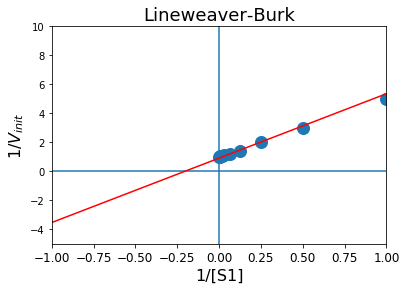

In [148]:
#### plot Lineweaver-Burk
inv_S1 = np.power(S1range,-1) # calculate 1/[S1]
inv_Vinit = np.power(Vinit,-1) # calculate 1/[Vinit]

fig = plt.plot(inv_S1, inv_Vinit, marker='o', linestyle="none",
               markersize=12)
plt.xlabel("1/[S1]", fontsize=16)
plt.ylabel("1/$V_{init}$", fontsize=16)
plt.title("Lineweaver-Burk", fontsize=18)
plt.xticks(fontsize=12)
plt.xlim((-1,1)) # set x-axis range
plt.ylim((-5,10)) # set y-axis range
plt.axvline(x=0) # vertical line at x-axis
plt.axhline(y=0) # horizontal line at y-axis

# Linear Regression Curve Fitting
# https://data36.com/linear-regression-in-python-numpy-polyfit/ 
model = np.polyfit(inv_S1, inv_Vinit, 1)
model
predict = np.poly1d(model)
x_lin_reg = np.linspace(-max(inv_S1), max(inv_S1), 10)
y_lin_reg = predict(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg, c = 'r')

print("Vmax = " + str(np.power(predict(0), -1)))
print("Km = " + str(model[0]/model[1]))

** Now Let's re-run the simulation but using a different kinetic parameter

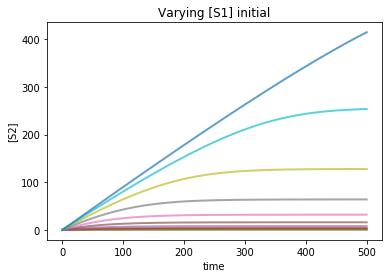

In [149]:
## additional simulation for comparing the effect of tuning parameters
r.kr = 50 ## dissociation rate constant
# varying S1 initial
r['[S1]'] = 0

r.reset() # re-seting simulation result
m2 = r.simulate (0, 500, 1000, selections=["time"]) #make time array


for i in range (0,len(S1range)):
    r.reset()
    r['[S1]'] = S1range[i] # set substrate concentration level
    res = r.simulate (0, 500, 1000, selections=["S2"])
    m2 = np.concatenate([m2, res], axis=1)
    #print("pp"+ str(i))

    
    
#### plot timecourse increments of reaction product    
# te.plotArray generate a plot using the first column of the array for dependent variable and other columns as independent variables

te.plotArray(m2, alpha=0.7, loc=None,
             xlabel="time", ylabel="[S2]", title="Varying [S1] initial");

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 <a list of 8 Text xticklabel objects>)

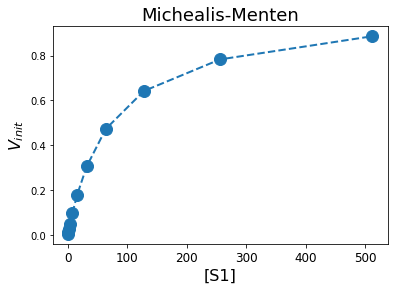

In [150]:
#### plot Michealis-Menten
# estimate reaction rate
# find time point where [S2] is half of [S2]max

initM = m2[0, 1:]
finalM = m2[-1,1:] # [S2] at final time point ~ [S2]max ** first column ~ time
timecourseM = m2[:,1:] # timecourse [S2] for each different initial [S1]
#print(finalM)

#find the differences between 1/2 [S2]max and each [S2] value in the timecourse
#the minimal absolute difference would be where [S2] ~ 1/2 [S2]max
diffMmid = abs(timecourseM-(finalM/2)) 
# find that minimum difference values
minInColumns = np.amin(diffMmid, axis=0)
# find the index where where [S2] ~ 1/2 [S2]max
ind = np.where(minInColumns == diffMmid)[0] # index of mid time
timepoint = m2[:, 0] # time point array from time course simulation 
thalf = timepoint[ind] # find out at what time point when [S2] ~ 1/2 [S2]max

# estimate initial reaction velocity
Vinit2 = ((finalM/2) - initM) / thalf

fig = plt.plot(S1range, Vinit2, marker='o', linestyle='dashed',
              linewidth=2, markersize=12)
plt.xlabel("[S1]", fontsize=16)
plt.ylabel("$V_{init}$", fontsize=16)
plt.title("Michealis-Menten", fontsize=18)
plt.xticks(fontsize=12)

Vmax = 1.0998878626352095
Km = 4.888229598081494


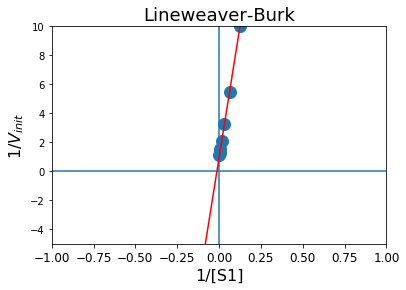

In [151]:
#### plot Lineweaver-Burk
inv_S1 = np.power(S1range,-1) # calculate 1/[S1]
inv_Vinit2 = np.power(Vinit2,-1) # calculate 1/[Vinit]

fig = plt.plot(inv_S1, inv_Vinit2, marker='o', linestyle="none",
               markersize=12)
plt.xlabel("1/[S1]", fontsize=16)
plt.ylabel("1/$V_{init}$", fontsize=16)
plt.title("Lineweaver-Burk", fontsize=18)
plt.xticks(fontsize=12)
plt.xlim((-1,1)) # set x-axis range
plt.ylim((-5,10)) # set y-axis range
plt.axvline(x=0) # vertical line at x-axis
plt.axhline(y=0) # horizontal line at y-axis

# Linear Regression Curve Fitting
# https://data36.com/linear-regression-in-python-numpy-polyfit/ 
model2 = np.polyfit(inv_S1, inv_Vinit2, 1)
model2
predict2 = np.poly1d(model2)
x_lin_reg = np.linspace(-max(inv_S1), max(inv_S1), 10)
y_lin_reg2 = predict2(x_lin_reg)
plt.plot(x_lin_reg, y_lin_reg2, c = 'r')

print("Vmax = " + str(np.power(predict(0), -1)))
print("Km = " + str(model[0]/model[1]))

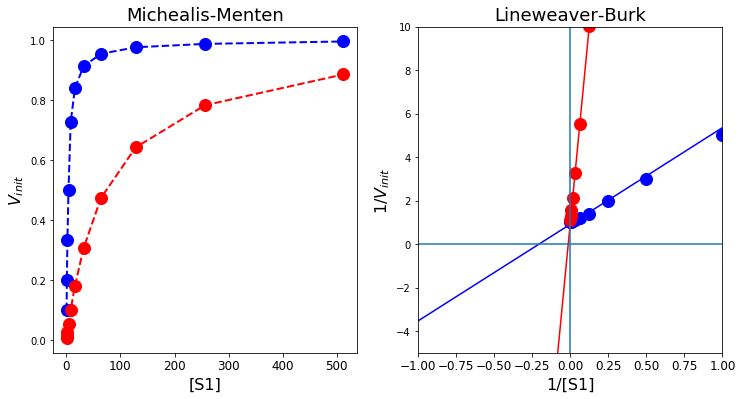

In [152]:
# comparing result from the two simulation
# Michealis-Menten
plt.subplots(figsize=(12,6 )) # set figure size
plt.subplot(1,2,1)

plt.plot(S1range, Vinit, marker='o', linestyle='dashed', color = 'b',
              linewidth=2, markersize=12)

plt.plot(S1range, Vinit2, marker='o', linestyle='dashed', color = 'r',
              linewidth=2, markersize=12)

plt.xlabel("[S1]", fontsize=16)
plt.ylabel("$V_{init}$", fontsize=16)
plt.title("Michealis-Menten", fontsize=18)
plt.xticks(fontsize=12)



# Lineweaver-Burk
plt.subplot(1,2,2)

plt.plot(inv_S1, inv_Vinit, marker='o', linestyle="none", color = 'b',
               markersize=12)
plt.plot(x_lin_reg, y_lin_reg, c = 'b')

plt.plot(inv_S1, inv_Vinit2, marker='o', linestyle="none", color = 'r',
               markersize=12)
plt.plot(x_lin_reg, y_lin_reg2, c = 'r')

plt.xlabel("1/[S1]", fontsize=16)
plt.ylabel("1/$V_{init}$", fontsize=16)
plt.title("Lineweaver-Burk", fontsize=18)
plt.xticks(fontsize=12)
plt.xlim((-1,1)) # set x-axis range
plt.ylim((-5,10)) # set y-axis range
plt.axvline(x=0) # vertical line at x-axis
plt.axhline(y=0) # horizontal line at y-axis


